# Model Selection

The task of producing the most suitable predictive model from a dataset has many nuances. In particular, there are two aspects that need to be defined experimentally before starting to adjust a model:

* At first, it may not be clear which learning algorithm is best suited to be used in a given situation.

* In addition, each learning algorithm has its own set of *hyperparameters*, which are the parameters of the algorithm itself, to counter the concept of *parameter* of the ML model to be adjusted.

Model selection is the process of selecting one of different learning algorithms (e.g., SVM, decision tree learning, logistic regression, etc.) or, once the learning algorithm is selected, choosing between different values ​​of hyperparameters (e.g., in polynomial regression, deciding which polynomial degree to use during training).

For a given prediction task, the choice of the most appropriate learning algorithm (and its respective hyperparameter values) is made based on some *estimate* of the generalization error obtained on unused data during training. In other words, different candidate models are evaluated during model selection. The model that has the best predictive performance (according to some pre-established assessment measure) is selected as a result of the model selection process.

# Two-way holdout method

In classification or regression tasks, it is very common to split the available observations (original dataset ) in two datasets:

* training dataset: used for training a model M
* test dataset: used to estimate the *generalization error* of M

This splitting method is commonly named *two-way holdout method*, or simply *holdout method*. This two-way split is illustrated in the image below ([source](https://www.datavedas.com/holdout-cross-validation/)).

![alt text](https://www.datavedas.com/wp-content/uploads/2018/04/image001-768x368.jpg)



In Scikit-Learn, we can apply the holdout method by using the `train_test_split` function. This function receives as input a data matrix $X$ and response vector $y$.

The following image illustrates the effect of applying the function `train_test_split`. As a result, two data matrices and two response vectors are created.

![alt text](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1543836883/image_6_cfpjpr.png)

Please notice that, each time `train_test_split` is called, it randomly selects which examples to put in the training and test datasets.

## Three-way holdout method

The application of the two-way holdout method can lead to a misleading estimate of the generalization error if the test data is also used for model selection.

Since the test dataset should ideally be used only to produce an estimate of the generalization error **after** training, it is common (at least for relatively large data sets) to further divide the training set into two subsets. The result of this is the production of three datasets, as described below.

* Training set: used to adjust the parameters for several candidate models.

* Validation set: used to adjust the hyperparameters of the ML algorithm. The predictive performance on this set is used for model selection. i.e., choose the best candidate model.  

* Test set: used once to obtain an estimate of the generalization error for the chosen candidate model.

The image below ([source](https://www.datavedas.com/holdout-cross-validation/)) illustrates the three-way split of the original dataset.

![alt text](https://www.datavedas.com/wp-content/uploads/2018/04/image003.jpg)

The image below ([source](https://datascience.stackexchange.com/questions/52632/cross-validation-vs-train-validate-test)) summarizes the model selection process for a given learning algorithm using the three data sets described above. Initially, the original data set is divided into two subsets, training and testing. Then, the training set is again divided into two, which generates the training, validation and test sets. After that, for each desired combination of hyperparameter values, a model is adjusted on the training set, and its performance on the validation set is computed. In this way, for each of the $ q $ combinations of hyperparameter values, $ q $ performance estimates are obtained. The predictive model corresponding to the combination of hyperparameter values ​​that produces the best performance estimate is selected. Finally, the generalization error estimate for this selected model is produced using the test set.

![alt text](https://i.stack.imgur.com/osBuF.png)

The procedure illustrated in the figure above can be performed once for each of the different learning algorithms candidates in a supervised learning task.

### Split proportions

Reserving  a test dataset to compute an estimate of the generalization error has the negative side effect of retaining potentially valuable information that the learning algorithm could benefit from. Therefore, choosing the size of the test set  involves a trade-off: allocating a very large test set can retain a lot of information that could be used to improve model fit during training. On the other hand, the smaller the test set, the more inaccurate the generalization error estimate is.

In most practical cases, the most used divisions are 60:40,
70:30 or 80:20, depending on the size of the initial data set.

However, for large data sets, 90:10 or even 99: 1 may be appropriate, since 10% (or even 1%) of a very large sample can still be statistically significant.

A common practice is to re-train the estimator on the entire data set (i.e., rejoining the training and test sets), in order to improve predictive performance of the resulting final model.

## $k$-fold Cross-validation

There are two disadvantages of the holdout method:

* the performance estimate can be very sensitive to the way used to subdivide the training set into the training and validation sets: this estimate will vary for different data samples. Repeating the holdout validation on different subsets of the data would provide a better estimate of the algorithm's performance.

* a significant part of the data is not used for training the model. For example, if the split ratio is 50%, half of the data set does not contribute to model training! This can cause problems, especially if the initial data set is small.

A more robust technique for performing model selection is *k-fold cross-validtion*. This technique corresponds to applying the holdout method $k$ times over $k$ different configurations of training and validation subsets.

The following figure ([source](https://sebastianraschka.com/faq/docs/evaluate-a-model.html)) illustrates $k$-fold cross validation. This is an iterative technique. In the first iteration, the training set is subdivided into $k$ disjunct sets (in the figure, $k = 10$). Then, $k-1$ of these subsets are used to fit the predictive model. Once the model has been adjusted, its error is estimated in the examples of the subset that was not used during the adjustment, which produces the value $E_1$ in the figure. In the second iteration, another fold is selected to compute the estimate and again a model is adjusted, which allows to compute another estimate of the error, $E_2$. In all, $k$ iterations are performed, which results in $k$ performance estimates. Finally, a more robust (i.e., less biased) estimate of the model error is obtained by computing the average of the previously produced $k$ estimates.

![alt text](https://sebastianraschka.com/images/faq/evaluate-a-model/k-fold.png)

Keep in mind that, as k increases:
* Bias in the estimation of the generalization error decreases;
Computational cost also increases.
* Empirical evidence shows that k=10 is a good value for datasets of moderate size.
* For large sized datasets, k can be safely decreased.


### Function cross_val_score

In the following example, the $k$-fold cross-validation technique is applied, with $k = 2$. The result is two performance estimates, which can be combined (for example, taking the average) to obtain a better measure of the model's generalization performance. This specific form of cross-validation is double cross-validation: we split the original data into two subsets and use each one as a validation set.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Configures k-NN with 1 neighbor
model = KNeighborsClassifier(n_neighbors=1)

iris = load_iris()
X = iris.data
y = iris.target

# divide the original dataset in 2 equal parts
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

# ajusta e avalia DOIS modelos

y1_model = model.fit(X1, y1).predict(X2)
y2_model = model.fit(X2, y2).predict(X1)

accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.36, 0.36)

Implementing $k$-fold cross validation using the approach illustrated in the previous example can be time consuming for greater values of $k$.

Scikit-Learn provides the function [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). This function makes it easier to apply $k$-fold cross validation.

It returns a NumPy array with an accuracy value for each fold. Notice that, for each fold, the training and tests sets will be different. Therefore, different accuracy values for each fold will be produced. Also notice that we can compute the mean and standard deviation of the resulting accuracies.

The following example illustrates the application of the function cross_val_score to the case $k = 10$.

In [3]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=10)
print('Scores in each fold: ', scores)
print('Average score: ', scores.mean())
print('Std deviation of scores: ', scores.std())

Scores in each fold:  [1.         0.93333333 1.         0.93333333 0.86666667 1.
 0.86666667 1.         1.         1.        ]
Average score:  0.96
Std deviation of scores:  0.05333333333333332


Scikit-Learn implements several cross-validation schemes that are useful in particular situations; these are implemented through iterators in the cross_validation module. In practice, we have to define the iterator through the `cv` parameter.

As an example, we might want to go to the extreme case where the number of subsets is equal to the number of examples contained in the training set. In this case, in each iteration, a model is fitted using all but one example, and accuracy is measured against the only example not used during training. This type of cross-validation is known as **leave-one-out cross-validation**.

The example below illustrates the use of this particular case leave-one-out cross-validation. Since there are 150 samples, the leave-one-out cross-validation produces 150 estimates (1.0 indicates a successful forecast, and 0.0 indicates an unsuccessful one).

In [4]:
from sklearn.model_selection import LeaveOneOut

scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The average of these 150 values ​​corresponds to the estimated error rate of the model produced:

In [5]:
print('Average score: ', scores.mean())
print('Std deviation of scores: ', scores.std())

Average score:  0.96
Std deviation of scores:  0.19595917942265423


## Stratified k-fold cross-validation

In the context of the classification task, an unbalanced presents as unequal proportion of examples for each class. See the image below ([source](https://www.researchgate.net/publication/306376881_Survey_of_resampling_techniques_for_improving_classification_performance_in_unbalanced_datasets)) for an example.

![alt text](https://miro.medium.com/max/698/1*cd6AorHoJYMFyj7IZd2nOg.png)

For unbalanced datasets, if the vanilla version of $k$-fold cross-validation is used, it can be the case that one or more produced folds end up with zero examples of a particular class. In such situations, it is better to use *stratified $k$-fold cross-validation*. In stratified $k$ cross-validation, class proportions are preserved in each of the $k$ subsets, so that each one is representative of the class proportions in the training data set. The image below (source) illustrates how stratified $k$-fold crors-validation works.

![alt text](https://miro.medium.com/max/562/0*QKJTHrcriSx2ZNYr.png)

In Scikit-Learn, the `StratifiedKFold` class implements the stratified cross-validation method. See the following example, that applies stratified cross-validation to a toy dataset with two classes. Notice that the proportions os classes in each fold is approximately the same as the original dataset.

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# data matrix
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [5, 6], [7, 8],
              [9, 10], [9, 10], [11, 12], [11, 12],
              [1, 2], [3, 4], [5, 6], [7, 8], [4, 5], [5, 6], [7, 8], [4, 5]])

# response vector
y = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

print(skf)

# print the indices of examples in each fold
for train_index, test_index in skf.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [ 3  4  5 12 13 14 15 16 17] TEST: [ 0  1  2  6  7  8  9 10 11]
TRAIN: [ 0  1  2  6  7  8  9 10 11] TEST: [ 3  4  5 12 13 14 15 16 17]


# Hyperparameter optimization

In contrast to the model parameters that are learned during training, the values ​​of the hyperparameters are set before the training of a model begins. Some examples of hyperparameters are given below.

* the learning rate in logistic regression and in linear regression,
* the height of trees in decision tree learning,
* the value of $k$ in $k$-NN,
* the value of $k$ in $k$-means,
* the values of $\epsilon$ and $\operatorname{minPoints}$ in DBSCAN,
* the regularization term in linear regression,
* the polynomial degree in polynomial regression.


Hyperparameters can be considered as configurations of a learning algorithm. In general, the ideal settings for the algorithm to generate a suitable model for one dataset may not be the same for another dataset.

*Hyperparameter optimization* (aka *hyperparameter tuning*) is the procedure of defining appropriate values for the hyperparameters of a given learning algorithm. The general approach is to generate several combinations of hyperparameter values. Then, a model is trained for each combinatation. Finally, the best combination (according to some evaluation measure applied on the candidate models) is chosen.

When the learning algorithm generates an estimator (either a classifier or a regressor), there are two main strategies to *automatically* tune its hyperparameters: *Grid Search* and *Random Search*. Both strategies generate several hyperparameter combinations. Then, for each combination, an estimator is trained a model (on the training set) and evaluateed (on the validation set). The difference between these two strategies is in the way the several combinations are generated, as described below.

**Grid search** first defines a grid of hyperparameter combinations. The amount of hyperparameters defines the number of dimensions in the grid. Then, each combination (a point in the grid) ​​is used to produce a model.

The image below ([source](https://www.researchgate.net/publication/271771573_TuPAQ_An_Efficient_Planner_for_Large-scale_Predictive_Analytic_Queries/figures?lo=1)) illustrates the GS procedure for a learning algorithm with two hyperparameters. The star represents the combination of hyperparameters that gives the best model. as measured in the validation set. The red dot in picture on the left represents the first combination test by GS. The picture on the center represents the second combination. The picture on the right illustrates all the tested combinations in the 2-dimensional grid.

![texto alternativo](https://www.researchgate.net/profile/Michael_Jordan13/publication/271771573/figure/fig4/AS:668513593217027@1536397469229/Illustration-of-naive-grid-search-for-a-single-model-family-with-two-hyperparameters_W640.jpg)

**Random search** selects random combinations of hyperparameter values ​​(within preconfigured ranges of values for each hyperparameter) to train and evaluate the candidate models. Instead of trying all possible combinations of values, RS performs a pre-defined number of iterations, testing a random combination of hyperparameters ​​in each iteration.

Both GS and RS can be very computationally expensive. For example, searching for 20 different values ​​for each of 4 hyperparameters would require 160,000 k-fold cross-validation runs. If $k = 10$ then 1,600,000 model adjustments and 1,600,000 evaluations should be performed

The image below ([source](https://community.alteryx.com/t5/Data-Science/Hyperparameter-Tuning-Black-Magic/ba-p/449289)) illustrates the difference between GS and RS. Think of a learning algorithm with just two hyperparameters. This way, each combination of its hyperparameters is a pair of numbers. Suppose one of these hyperparameters (x-axis) has more influence than the other (y-axis) on the predictive performance of the generated models. The plot on the left shows several of these pairs organized in a grid. In total, there are thirty combination in this grid. The picture on the right shows other combinations of pairs; this times these combinations where randomly selected. Notice that RS has the potential to explore more promising combinations than GS.

![texto alternativo](https://pvsmt99345.i.lithium.com/t5/image/serverpage/image-id/74545i97245FDAA10376E9/image-size/large?v=1.0&px=999)

In Scikit-Learn, the classes [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) implement GS and RS, respectively.

### Class GridSearchCV

Scikit-Learn provides the class `GridSearchCV` to perform grid search.

The following code block presents an example of using the `GridSearchCV` class to find the ideal polynomial model for a data set. In this example, a three-dimensional grid of hyperparameters is explored:

* the polynomial degree,
* a boolean indicator that indicates whether the linear coefficient should be adjusted,
* an indicator (boolean) indicating whether the data should be normalized.

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [8]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False]}

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

In [9]:
X, y = make_data(40)
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X, y)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])})

In [12]:
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}

In [10]:
#pip install seaborn

(-2.0, 12.0)

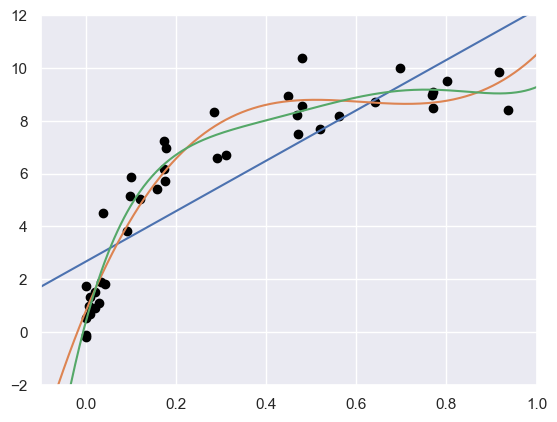

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)

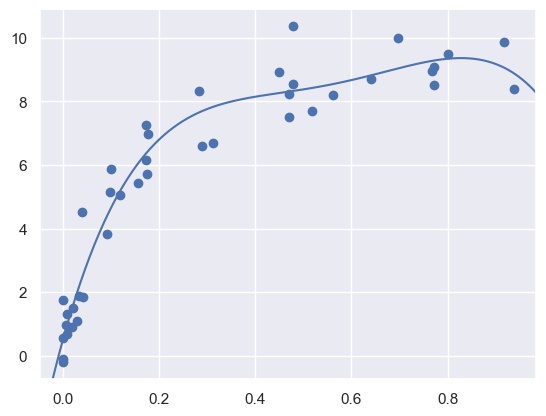

In [13]:
import matplotlib.pyplot as plt

model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

### Class RandomizedSearchCV

This allows you to explicitly control the number of parameter combinations that are attempted. The number of search iterations is defined based on time or resources. Scikit Learn offers the RandomizedSearchCV function for this process.


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from timeit import default_timer as timer
from sklearn.svm import LinearSVC

def linear_SVC(x, y, param, kfold):
    param_grid = {'C':param}
    k = StratifiedKFold(n_splits=kfold)
    grid = GridSearchCV(LinearSVC(dual=False), param_grid=param_grid, cv=k, n_jobs=4, verbose=1)

    return grid.fit(x, y)

def Linear_SVC_Rand(x, y, param, kfold, n):
    param_grid = {'C':param}
    k = StratifiedKFold(n_splits=kfold)
    randsearch = RandomizedSearchCV(LinearSVC(dual=False), param_distributions=param_grid, cv=k, n_jobs=4,
                                    verbose=1, n_iter=n)

    return randsearch.fit(x, y)

from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


start = timer()
param = [i/1000 for i in range(1,1000)]
param1 = [i for i in range(1,101)]
param.extend(param1)

#progress = progressbar.bar.ProgressBar()
clf = Linear_SVC_Rand(x=x_train, y=y_train, param=param, kfold=3, n=100)

print('LinearSVC:')
print('Best cv accuracy: {}' .format(clf.best_score_))
print('Test set score:   {}' .format(clf.score(x_test, y_test)))
print('Best parameters:  {}' .format(clf.best_params_))
print()

duration = timer() - start
print('time to run RandomizedSearchCV: {}' .format(duration))


print('########')

#high C means more chance of overfitting

start = timer()
param = [i/1000 for i in range(1,1000)]
param1 = [i for i in range(1,101)]
param.extend(param1)

clf = linear_SVC(x=x_train, y=y_train, param=param, kfold=3)

print('LinearSVC:')
print('Best cv accuracy: {}' .format(clf.best_score_))
print('Test set score:   {}' .format(clf.score(x_test, y_test)))
print('Best parameters:  {}' .format(clf.best_params_))
print()

duration = timer() - start
print('time to run GridSearchCV: {}' .format(duration))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


LinearSVC:
Best cv accuracy: 0.975
Test set score:   1.0
Best parameters:  {'C': 54}

time to run RandomizedSearchCV: 6.034947991982335
########
Fitting 3 folds for each of 1099 candidates, totalling 3297 fits
LinearSVC:
Best cv accuracy: 0.975
Test set score:   1.0
Best parameters:  {'C': 8}

time to run GridSearchCV: 4.930534393992275


In [15]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

# build a classifier
clf = RandomForestClassifier(n_estimators=20)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 7.79 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.930 (std: 0.032)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.925 (std: 0.027)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.923 (std: 0.031)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 6}

GridSearchCV took 31.68 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.934 (std: 0.020)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.932 (std: 0.022)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_fe

# Model selection: practical tips

* It is appropriate to start with a simple algorithm that can be used quickly.

* Use learning curves to decide for more (or less) data, more (or less) attributes, etc.

* Another technique used in model selection is *error analysis*, which corresponds to manually checking the examples (in the validation set) that the algorithm has erred. It is sometimes possible to detect a pattern of systematic error in these examples.

* The motivation for using k-fold cross-validation is to be able to use a good amount of test or validation data, without significantly reducing the training data set. In situations where there is enough data to have a good-sized training data set, in addition to reasonable amounts of test and validation data, holdout cross validation can be used.


# Case Study: Housing dataset


In this case study, we will use the *Housing* dataset to practice some concepts related to hyperparameter optimization. This dataset contains information about residences in Boston/USA. There are 506 samples and 13 variables in this dataset. This dataset is used to train regressors, in which the objective is to predict the value of home prices (MEDV feature) using the predictive features provided. This dataset can be loaded with the Scikit-Learn library, according to the code block below.

In [16]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("../data", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [17]:
fetch_housing_data()

In [18]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [19]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Exercise 1

a) Perform the split of the Housing dataset into training and test subsets using holdout strategy. Set aside 80% of the data for training. After that, build a OLS regression model with that split, and evaluate the MSE in the test dataset.

b) Repeat the previous experiment, this time using $k$-fold cross validation instead of the hold-out strategy. Use $k = 5$.

### Solutions

### 1a

We can use the function `train_test_split` to create a training dataset with  80% of the examples, as requested.

To standardize the data, the StandardScaler class was used, which transforms each data feature to have $\mu = 0$ and $\sigma^2 = 1$.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

boston = housing

X = boston.drop(columns=['median_house_value'])
y = boston['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('MSE: %.2f' % mean_squared_error(y_test, y_pred))

(16512, 9)
(4128, 9)


ValueError: could not convert string to float: 'NEAR OCEAN'

### 1b

For the k-fold validation, five data divisions were performed between training and testing using the `cross_validate` function with MSE evaluation metric.


In [ ]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

X = boston.drop(columns=['median_house_value'])
y = boston['median_house_value']

reg = LinearRegression()

scores = cross_validate(reg, X, y, cv=5, scoring='neg_mean_squared_error')

print(scores)
print(-scores['test_score'].mean())

{'fit_time': array([0.02314186, 0.02906609, 0.02760291, 0.02871895, 0.02768755]), 'score_time': array([0.01354218, 0.00713372, 0.0076654 , 0.00658011, 0.01895285]), 'test_score': array([-5.40111855e+09, -5.72536959e+09, -5.75385011e+09, -5.94042433e+09,
       -4.41703123e+09])}
5447558761.560663


## Exercise 2

Consider the following code block, which is intended to perform Grid Search on the `Housing` dataset. The `param_grid` parameter tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of` n_estimators` and `max_features` with hyperparameters specified in the first dict (don't worry about what these hyperparameters mean for the moment), and then try all 2 × 3 = 6 combinations of hyperparameter values ​​in the second dict, but this time with the `bootstrap` hyperparameter set to` False` instead of `True` (which is the default value).
In short, GS will explore 12 + 6 = 18 combinations of hyperparameter values ​​for the `RandomForestRegressor` algorithm.

  a) Based on the value of $k$ defined to perform the cross-validation in the code below, how many models will be adjusted during GS?

  b) Complete the code given below to tune the hyperparameters using Grid Search. What is the RMSE value for the best model?
  
  c) Use Random Search with 18 iterations. Is there a change in the  produced best combination of hyperparameter values, when compared to Grid Search? What is the new RMSE value?

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

### Solutions

### 2a

In total, 90 models will be trained by Grid Search as there are 18 parameters that will be combined and trained 5 times each

### 2b
The code below performs the hyperparameter tuning using Grid Search

In [ ]:
housing = pd.read_csv('../data/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Repare que o conjunto de dados possui preditores que não são numéricos e que há valores faltantes. Portanto, algum pré-processamento é necessário antes do ajuste do modelo.

In [ ]:
housing = pd.get_dummies(housing, drop_first=True)
housing = housing.fillna(housing.mean())

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   ocean_proximity_INLAND      20640 non-null  uint8  
 10  ocean_proximity_ISLAND      20640 non-null  uint8  
 11  ocean_proximity_NEAR BAY    20640 non-null  uint8  
 12  ocean_proximity_NEAR OCEAN  20640 non-null  uint8  
dtypes: float64(9), uint8(4)
memory 

Agora, os preditores devem ser transformados para possírem a mesma ordem de grandeza.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

housing_prepared = scaler.fit_transform(housing.drop(columns='median_house_value'))
housing_labels = housing.loc[:,'median_house_value'].values

In [ ]:
housing_labels

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
%time grid_search.fit(housing_prepared, housing_labels)

CPU times: user 1min 7s, sys: 796 ms, total: 1min 8s
Wall time: 1min 8s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [ ]:
import numpy as np

rmse = np.sqrt(-grid_search.best_score_)

rmse

72603.3950427287

### 2c

The code below performs hyperparameter tuning using Random Search


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()
random_search = RandomizedSearchCV(forest_reg,
                                   param_grid,
                                   cv = 5,
                                   scoring='neg_mean_squared_error',
                                   n_iter = 18,
                                   verbose = 2)
%time random_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....................max_features=2, n_estimators=3; total time=   0.1s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.2s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.1s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.2s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.5s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.5s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.5s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.5s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.4s
[CV] END ....................max_features=2, n_estimators=30; total time=   1.0s
[CV] END ....................max_features=2, n_e

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=18,
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
random_search.best_params_

{'n_estimators': 30, 'max_features': 2}

In [ ]:
import numpy as np
rmse = np.sqrt(-random_search.best_score_)
rmse

71090.91039715245

# Case Study: Wine Quality dataset

Let us see another case study of applying hyperparameter optimization. This time, we use the [Red Wine Quality dataset](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

wine_df = pd.read_csv('../data/winequality-red.csv')

wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


The histogram below shows that this is a highly unbalanced dataset.

<Axes: >

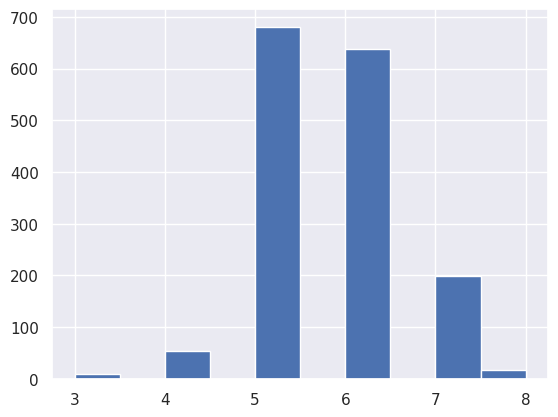

In [ ]:
wine_df.quality.hist()

To keep things simple, we frame the problem as a binary classification one. To do that, we build a new target (`high_quality`) from the original one (`quality`).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Build a new target
wine_df['high_quality'] = [1 if x >=7 else 0 for x in wine_df['quality']]

Now we have a binary classification problem. The new dataset is still unbalanced though.

In [ ]:
wine_df.high_quality.unique()

array([0, 1])

<Axes: >

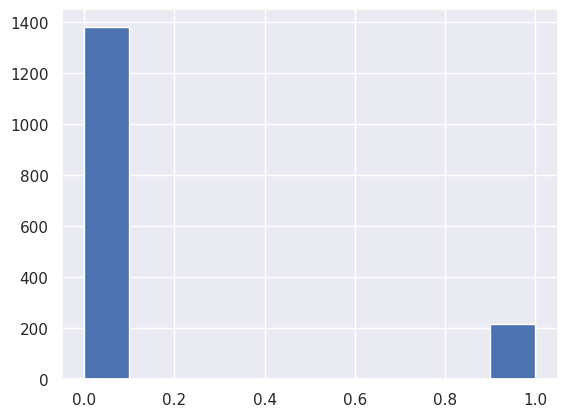

In [ ]:
wine_df.high_quality.hist()

Now we split the dataset. Notice we use the `stratify` option, since the dataset is unbalanced.

In [ ]:
# Separate features and target.
X = wine_df.drop(['quality'], axis=1)
X = wine_df.drop(['high_quality'], axis=1)
y = wine_df['high_quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Before fitting the model, we scale the data.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

As base classifier, we use [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). We focus on two of its hyperparameters, `C` and `gamma`.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Create parameter grid
param_grid = {'C': [.01, .1, 1, 10, 100, 1000, 10000],
              'gamma': [0.0001, 0.001, 0.01, .1, 1, 10, 100, 1000]}

# Create grid search
grid_search = GridSearchCV(SVC(),
                           param_grid,
                           cv=5)
# Fit grid search
%time grid_search.fit(X_train, y_train)

CPU times: user 13.2 s, sys: 24.4 ms, total: 13.2 s
Wall time: 13.3 s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]})

We can access all of the fits and scores after fitting the grid search. This is done by inspecting the `cv_results_` field.

In [ ]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012255,0.000180,0.005063,0.000172,0.01,0.0001,"{'C': 0.01, 'gamma': 0.0001}",0.866667,0.8625,0.8625,0.8625,0.866109,0.864055,0.001913,39
1,0.012274,0.000148,0.004872,0.000133,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.866667,0.8625,0.8625,0.8625,0.866109,0.864055,0.001913,39
2,0.012912,0.000515,0.005384,0.000749,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.866667,0.8625,0.8625,0.8625,0.866109,0.864055,0.001913,39
3,0.014748,0.000588,0.005491,0.000075,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.866667,0.8625,0.8625,0.8625,0.866109,0.864055,0.001913,39
4,0.036023,0.003117,0.013095,0.002094,0.01,1,"{'C': 0.01, 'gamma': 1}",0.866667,0.8625,0.8625,0.8625,0.866109,0.864055,0.001913,39


The results can be presented as a heatmap to facilitate the analisys.

<ipython-input-52-cd19aaef226c>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  hm_data = results.pivot(index='param_C',
<ipython-input-52-cd19aaef226c>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  hm_data = results.pivot(index='param_C',


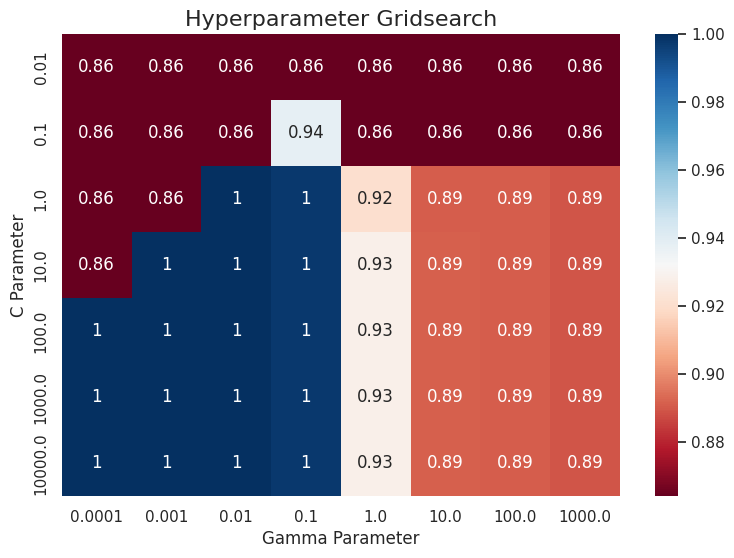

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pull results from grid search
hm_data = results.pivot(index='param_C',
                   columns='param_gamma',
                   values='mean_test_score')

# Plot heatmap
fix, ax = plt.subplots(figsize=(9, 6))

ax = sns.heatmap(hm_data,
                 annot=True,
                 cmap='RdBu',
                 linecolor='white')

ax.set_title('Hyperparameter Gridsearch', fontsize=16)
ax.set_ylabel('C Parameter', fontsize=12)
ax.set_xlabel('Gamma Parameter', fontsize=12)

plt.show()

In [ ]:
# Print best parameters and best score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Plug best parameters into the model, train it, and test on held out data
best_svc = SVC(**grid_search.best_params_).fit(X_train, y_train)

print("Score on the test set: {:.3f}".format(best_svc.score(X_test, y_test)))

Best parameters: {'C': 1, 'gamma': 0.01}
Best cross-validation score: 1.00
Score on the test set: 0.995


We now build a confusion matrix for the examples in the test set.


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = best_svc.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[346   0]
 [  2  52]]
